In [1]:
import sys
import os
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
import vis_utils
import misc_utils
import metric_utils

In [2]:
from generate_data import generate_nglf_from_model
from generate_data import generate_general_make_spd
from metric_utils import calculate_nll_score

In [3]:
import theano_time_corex

### Load some data

In [4]:
m = 8
bs = 16
nv = m * bs
train_cnt = 8
test_cnt = 100
nt = 5
(data, ground_truth) = generate_nglf_from_model(nv=nv, m=m, nt=nt, ns=train_cnt + test_cnt, snr=5.0)
train_data = [X[:train_cnt] for X in data]
test_data = [X[train_cnt:] for X in data]
ground_truth = [ground_truth] * nt

Fixed SNR: 5.0


In [5]:
grouth_truth_score = calculate_nll_score(data=test_data, covs=ground_truth)
print "Ground truth score = {}".format(grouth_truth_score)

Ground truth score = 189.625280736


In [6]:
whole_train_data = np.concatenate(train_data, axis=0)
print whole_train_data.shape

whole_test_data = np.concatenate(test_data, axis=0)
print whole_test_data.shape

(40, 128)
(500, 128)


### Linear Corex on whole data

In [7]:
import theano_linear_corex

In [8]:
corex = theano_linear_corex.Corex(nv=nv,
                                  n_hidden=m,
                                  max_iter=500,
                                  verbose=True,
                                  anneal=True)

corex.fit(whole_train_data)

Linear CorEx with 8 latent factors
tc = 8.85820792129, obj = -20.5739730075, eps = 0.6
tc = 13.2250138338, obj = -23.8715454553, eps = 0.6
tc = 16.621493395, obj = -23.001733842, eps = 0.6
tc = 19.2144397243, obj = -30.2686622327, eps = 0.6
tc = 21.4145679962, obj = -31.7149715733, eps = 0.6
tc = 23.1060410136, obj = -30.8423084657, eps = 0.6
tc = 24.4030264192, obj = -31.7345624025, eps = 0.6
tc = 25.5015132039, obj = -31.2438410334, eps = 0.6
tc = 26.5262671771, obj = -34.160287425, eps = 0.6
tc = 27.3417768063, obj = -36.3998589168, eps = 0.6
tc = 27.9896343804, obj = -36.5528168173, eps = 0.6
tc = 28.6729644338, obj = -39.1712800328, eps = 0.6
tc = 29.2585619765, obj = -38.2997276782, eps = 0.6
tc = 29.8116116641, obj = -38.4788883747, eps = 0.6
tc = 30.3437180077, obj = -39.9095724367, eps = 0.6
tc = 30.8098124025, obj = -38.1925531373, eps = 0.6
tc = 31.2671194606, obj = -39.1016197018, eps = 0.6
tc = 31.6569852931, obj = -38.8656491405, eps = 0.6
tc = 31.9668787246, obj = -39.55

tc = 100.376579012, obj = -100.68264075, eps = 0.07776
tc = 100.377715823, obj = -100.616843588, eps = 0.07776
tc = 100.353497895, obj = -101.035964495, eps = 0.07776
tc = 100.371162708, obj = -101.113241606, eps = 0.07776
tc = 100.372293603, obj = -100.85718741, eps = 0.07776
tc = 100.370247203, obj = -100.983243309, eps = 0.07776
tc = 100.371743452, obj = -100.622787372, eps = 0.07776
tc = 100.362040964, obj = -101.579061436, eps = 0.07776
tc = 100.372664033, obj = -101.487650815, eps = 0.07776
tc = 100.359545178, obj = -100.850151547, eps = 0.07776
tc = 100.375877325, obj = -100.592835651, eps = 0.07776
tc = 100.365864847, obj = -101.139345424, eps = 0.07776
tc = 100.379317014, obj = -100.99893239, eps = 0.07776
tc = 100.37278956, obj = -100.307330577, eps = 0.07776
tc = 100.385116046, obj = -101.264955051, eps = 0.07776
tc = 101.597722653, obj = -102.228069697, eps = 0.046656
tc = 101.568041569, obj = -102.170253035, eps = 0.046656
tc = 101.556058096, obj = -102.096872964, eps = 0.

<theano_linear_corex.Corex instance at 0x7f320ebae3b0>

In [9]:
linaer_corex_whole_score = calculate_nll_score(data=[whole_test_data], covs=[corex.get_covariance()])
print "Linear Corex (on whole data) score = {}".format(linaer_corex_whole_score)

Linear Corex (on whole data) score = 193.764156724


<IPython.core.display.Javascript object>


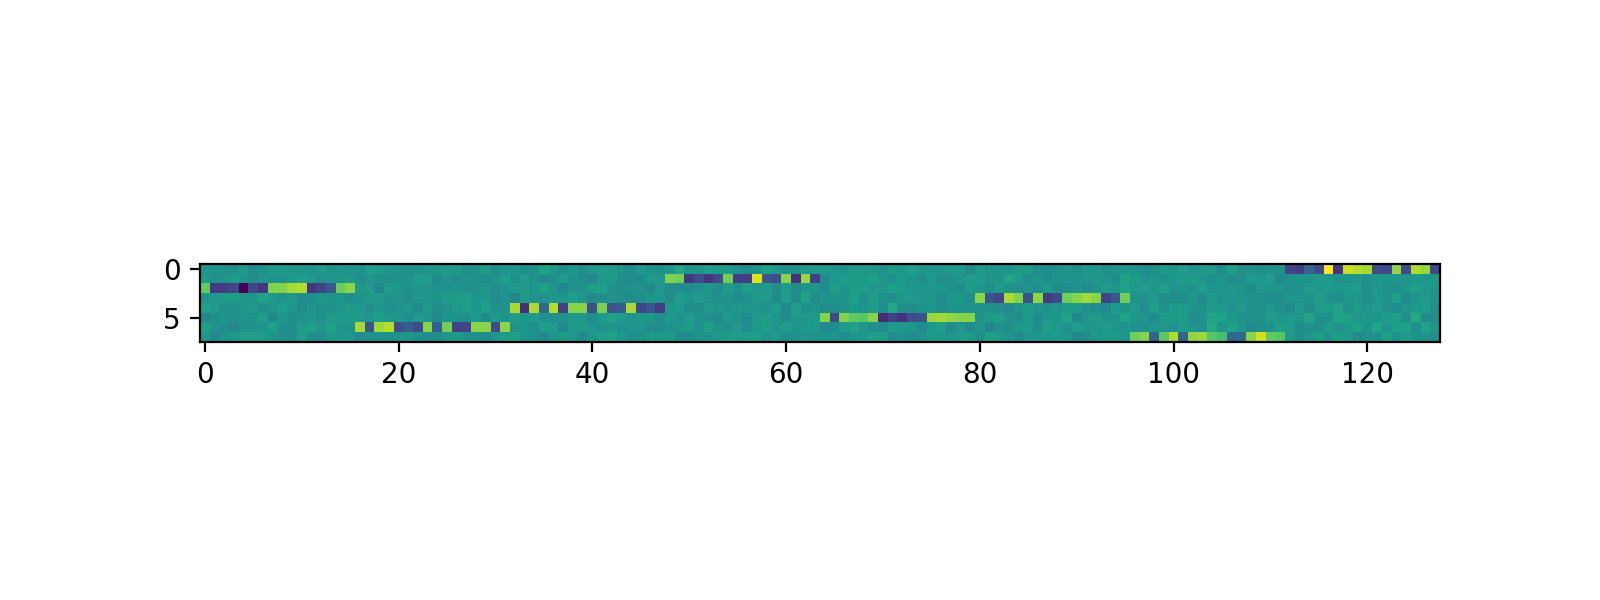

In [15]:
lc_W = corex.ws.get_value()
plt.figure(figsize=(8,3))
plt.imshow(lc_W)

### T-Corex

In [11]:
best_nll = np.inf
best_tcorex = None
best_l1 = None
coefs = [0, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1, 1.0, 3.0, 10.0, 100.0, 1000.0, 1e4, 1e5, 1e6]
t_corex_nlls = []
for l1 in coefs:
    print "training with l1 = {}".format(l1)
    tcorex = theano_time_corex.TimeCorexW(nt=nt,
                                        nv=nv,
                                        n_hidden=m,
                                        max_iter=500,
                                        verbose=False,
                                        anneal=True,
                                        l1=l1)
    tcorex.fit(train_data)
    tcorex_covs = tcorex.get_covariance()
    nll = metric_utils.calculate_nll_score(data=test_data, covs=tcorex_covs)
    t_corex_nlls.append(nll)
    print "l1 = {}, nll = {}".format(l1, nll)
    if np.mean(nll) < best_nll:
        best_nll = np.mean(nll)
        best_tcorex = tcorex
        best_l1 = l1

print "best l1 = {}".format(best_l1)
tcorex = best_tcorex
print sum(tcorex.tc)

training with l1 = 0
Annealing iteration finished, time = 0.606094837189
Annealing iteration finished, time = 0.602874040604
Annealing iteration finished, time = 0.607141017914
Annealing iteration finished, time = 0.600410938263
Annealing iteration finished, time = 0.602141141891
Annealing iteration finished, time = 0.610394001007
Annealing iteration finished, time = 0.606050014496
l1 = 0, nll = 233.438772697
training with l1 = 0.001
Annealing iteration finished, time = 0.624897003174
Annealing iteration finished, time = 0.637079000473
Annealing iteration finished, time = 0.629712820053
Annealing iteration finished, time = 0.623792886734
Annealing iteration finished, time = 0.635185956955
Annealing iteration finished, time = 0.62144112587
Annealing iteration finished, time = 0.62665605545
l1 = 0.001, nll = 233.750003828
training with l1 = 0.003
Annealing iteration finished, time = 0.632946968079
Annealing iteration finished, time = 0.620586872101
Annealing iteration finished, time = 0.

In [12]:
t_corex_score = best_nll
print "T-Corex score = {}".format(t_corex_score)

T-Corex score = 221.635340376


<IPython.core.display.Javascript object>


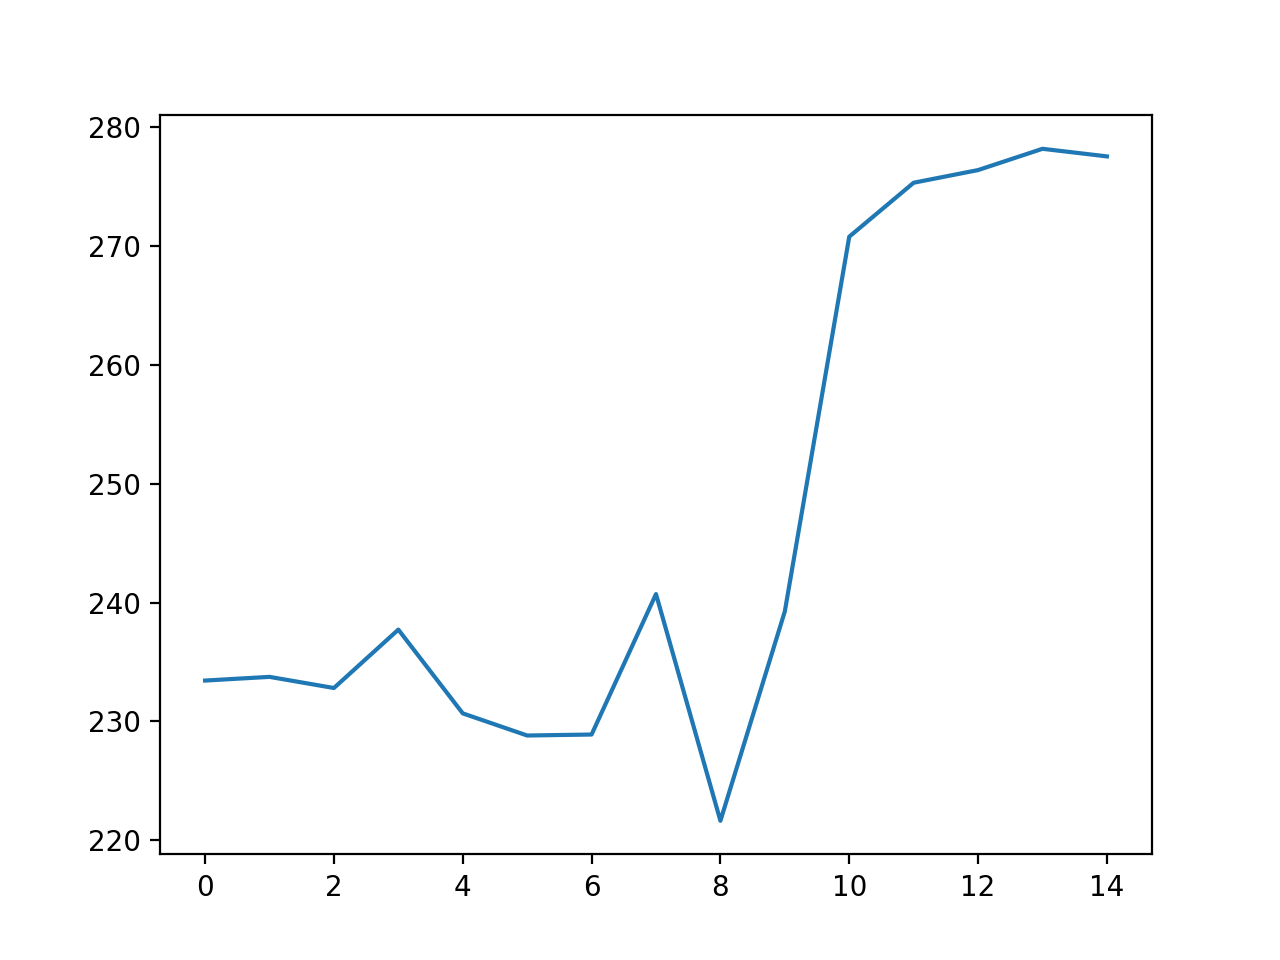

In [14]:
plt.figure()
plt.plot(t_corex_nlls)

In [16]:
W = [x.get_value() for x in tcorex.ws]

In [17]:
print "W_norm = {}".format(np.mean([np.abs(w).mean() for w in W]))

W_norm = 0.0892849116382


<IPython.core.display.Javascript object>


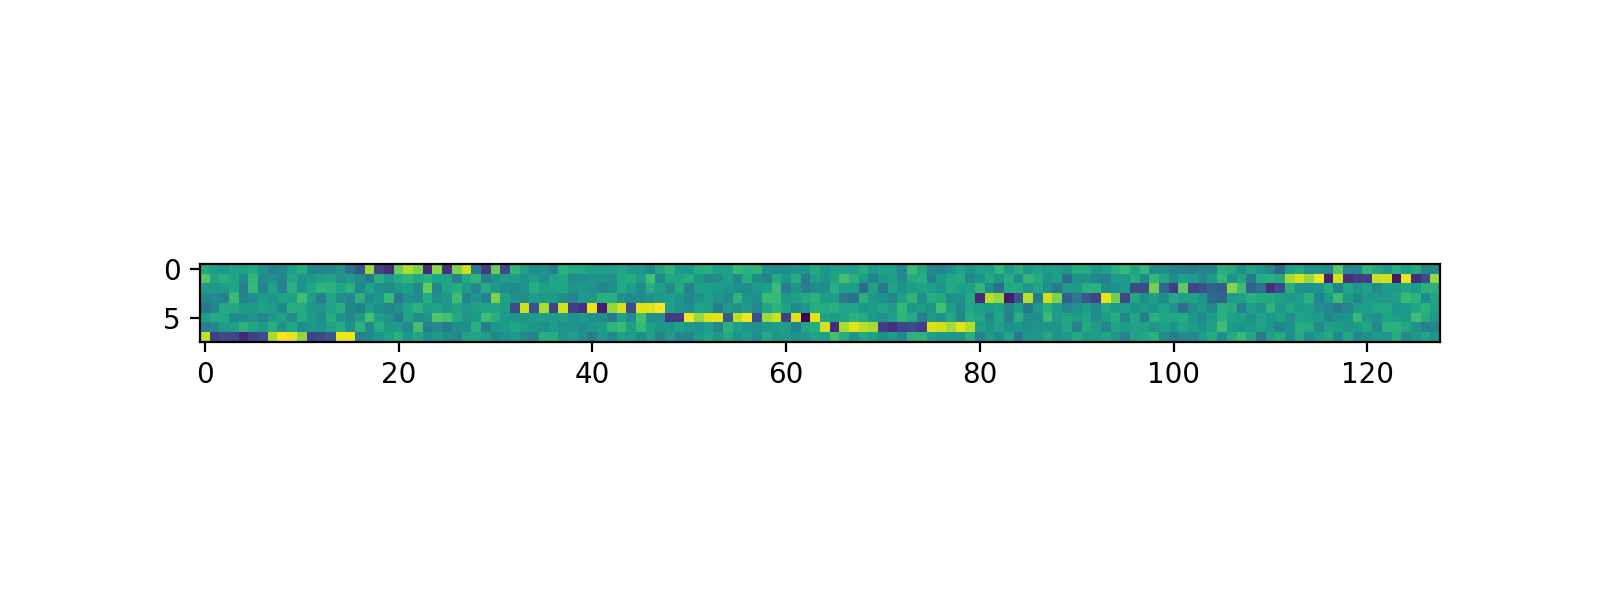

In [18]:
plt.figure(figsize=(8,3))
plt.imshow(W[0])

In [19]:
print "reg term = {}".format(np.mean([np.mean(np.abs(W[t+1]-W[t])) for t in range(nt-1)]))

reg term = 0.00023593566817


### learn T-Corex with pretraining

In [20]:
best_nll = np.inf
best_tcorex_pre = None
best_l1 = None
coefs = [0.0, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1, 1.0, 3.0, 10.0, 100.0, 1000.0, 1e4, 1e5, 1e6]
t_corex_pre_nlls = []
for l1 in coefs:
    print "training with l1 = {}".format(l1)
    tcorex_pre = theano_time_corex.TimeCorexW(nt=nt,
                                            nv=nv,
                                            n_hidden=m,
                                            max_iter=500,
                                            verbose=False,
                                            anneal=True,
                                            l1=l1,
                                            pretrained_weights=[lc_W]*nt)
    tcorex_pre.fit(train_data)
    tcorex_pre_covs = tcorex_pre.get_covariance()
    nll = metric_utils.calculate_nll_score(data=test_data, covs=tcorex_pre_covs)
    t_corex_pre_nlls.append(nll)
    print "l1 = {}, nll = {}".format(l1, nll)
    if np.mean(nll) < best_nll:
        best_nll = np.mean(nll)
        best_tcorex_pre = tcorex_pre
        best_l1 = l1

print "best l1 = {}".format(best_l1)
tcorex_pre = best_tcorex_pre
print sum(tcorex_pre.tc)

training with l1 = 0.0
Annealing iteration finished, time = 0.629492044449
Annealing iteration finished, time = 0.624620914459
Annealing iteration finished, time = 0.62372803688
Annealing iteration finished, time = 0.626152038574
Annealing iteration finished, time = 0.63151884079
Annealing iteration finished, time = 0.624138116837
Annealing iteration finished, time = 0.622329950333
l1 = 0.0, nll = 232.350437667
training with l1 = 0.001
Annealing iteration finished, time = 0.628539800644
Annealing iteration finished, time = 0.629889011383
Annealing iteration finished, time = 0.634182929993
Annealing iteration finished, time = 0.632500171661
Annealing iteration finished, time = 0.630300998688
Annealing iteration finished, time = 0.63875412941
Annealing iteration finished, time = 0.627920866013
l1 = 0.001, nll = 232.183118008
training with l1 = 0.003
Annealing iteration finished, time = 0.645436048508
Annealing iteration finished, time = 0.640812158585
Annealing iteration finished, time =

In [21]:
t_corex_pre_score = best_nll
print "T-Corex pretrained weights score = {}".format(t_corex_pre_score)

T-Corex pretrained weights score = 219.81957897


<IPython.core.display.Javascript object>


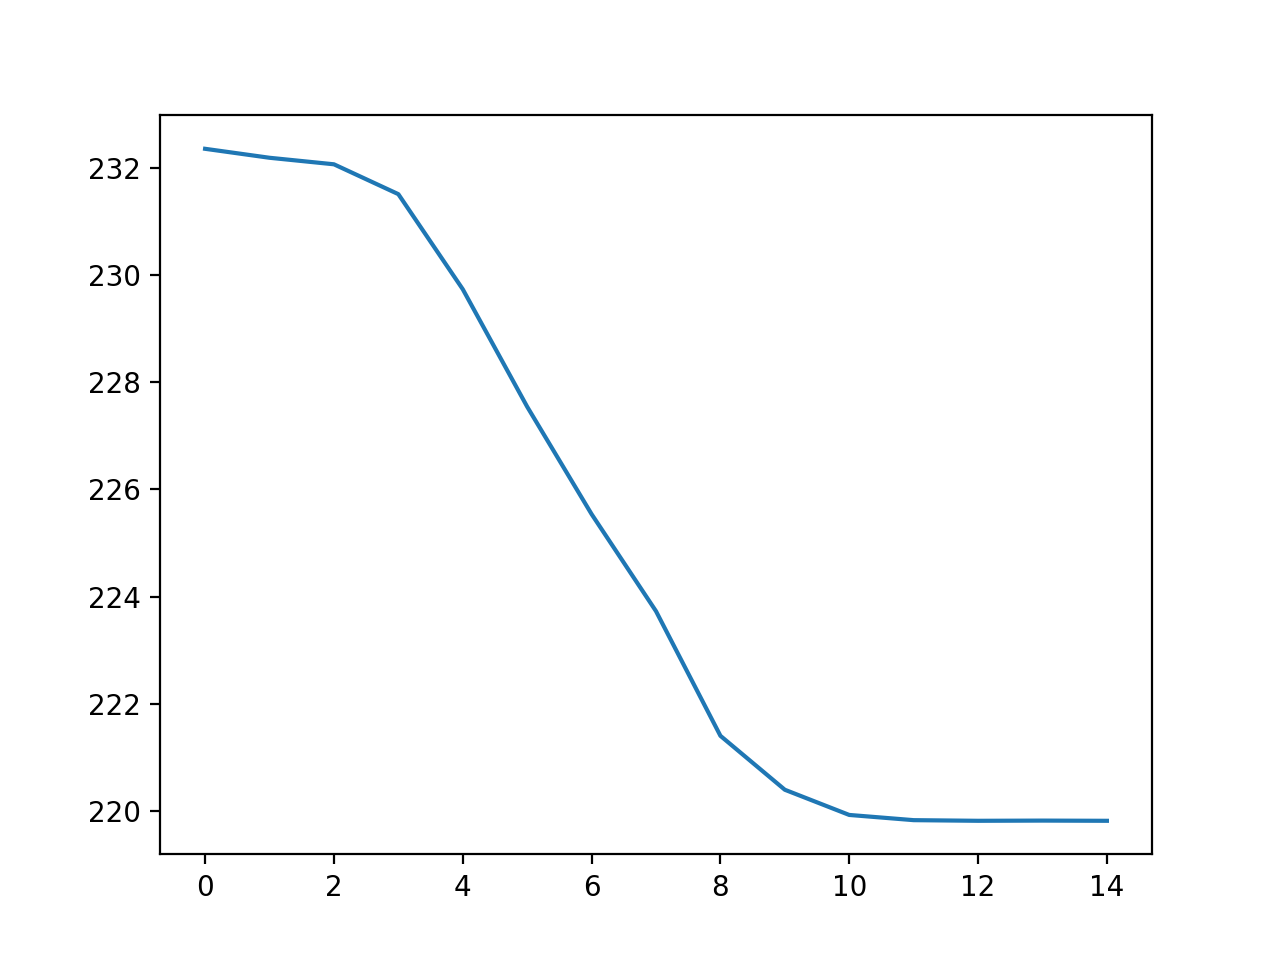

In [22]:
plt.figure()
plt.plot(t_corex_pre_nlls)

In [23]:
W = [x.get_value() for x in tcorex_pre.ws]

In [24]:
print "W_norm = {}".format(np.mean([np.abs(w).mean() for w in W]))

W_norm = 0.108425003458


<IPython.core.display.Javascript object>


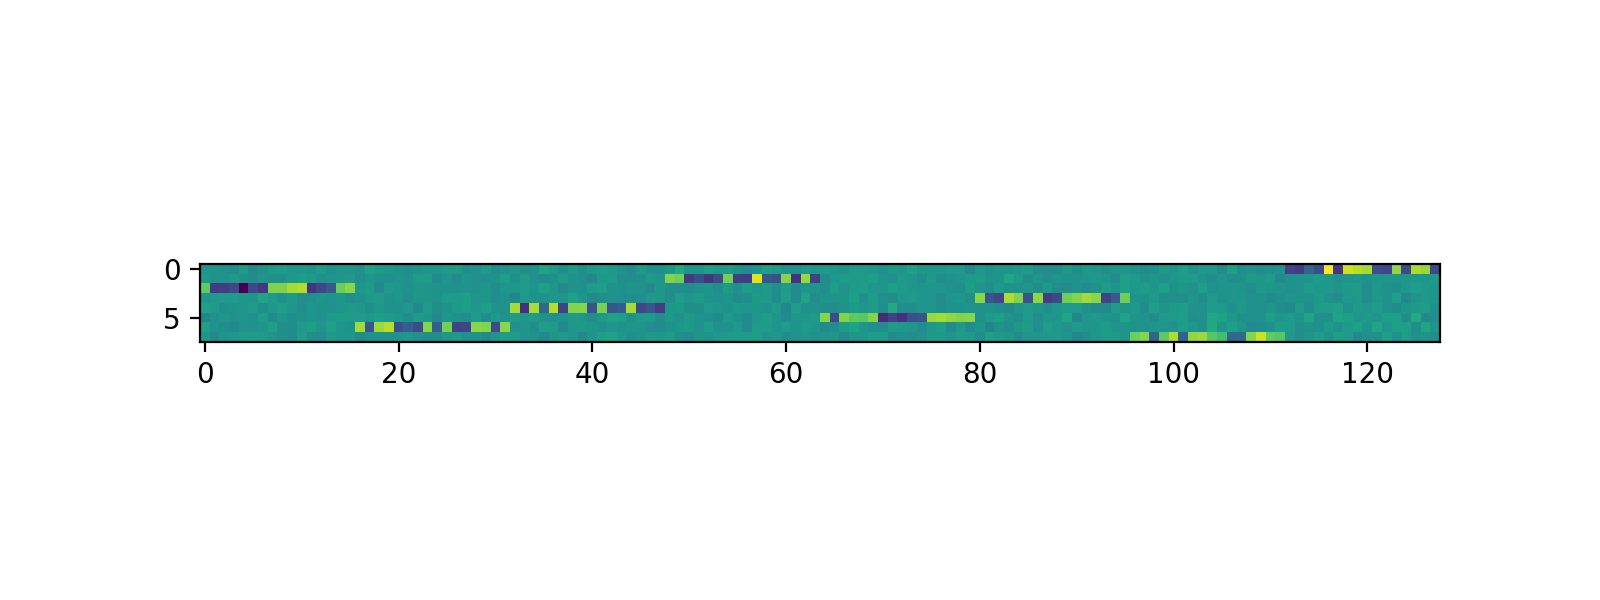

In [25]:
plt.figure(figsize=(8, 3))
plt.imshow(W[0])

In [26]:
print "reg term = {}".format(np.mean([np.mean(np.abs(W[t+1]-W[t])) for t in range(nt-1)]))

reg term = 0.000211786965463


### pretrianed weights no training

In [27]:
no_training = theano_time_corex.TimeCorexW(nt=nt,
                                            nv=nv,
                                            n_hidden=m,
                                            max_iter=500,
                                            verbose=False,
                                            anneal=True,
                                            pretrained_weights=[lc_W]*nt)

In [28]:
no_training.fit(train_data)

Annealing iteration finished, time = 0.615252971649
Annealing iteration finished, time = 0.610704898834
Annealing iteration finished, time = 0.621893882751
Annealing iteration finished, time = 0.613347053528
Annealing iteration finished, time = 0.620965957642
Annealing iteration finished, time = 0.615332126617
Annealing iteration finished, time = 0.616966962814


In [29]:
for x, w in zip(no_training.ws, [lc_W]*nt):
    x.set_value(w)
no_training._update_u(no_training.x_std)
no_training._calculate_moments(no_training.x_std, no_training.ws);

In [35]:
t_corex_no_training_pretrained_score = calculate_nll_score(data=test_data, covs=no_training.get_covariance())
print "T-Corex no training score, pretrained weights = {}".format(t_corex_no_training_pretrained_score)

T-Corex no training score, pretrained weights = 232.479628584


# Use priors for $Z_j^2$ and $R_{ji}$ (method 1)

In [36]:
best_nll = np.inf
best_tcorex_prior = None
best_l1 = None
coefs = [0.0, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1, 1.0, 3.0, 10.0, 100.0, 1000.0, 1e4, 1e5, 1e6]
t_corex_prior_nlls = []
for l1 in coefs:
    print "training with l1 = {}".format(l1)
    tcorex_prior = theano_time_corex.TimeCorexWPrior(nt=nt,
                                                    nv=nv,
                                                    n_hidden=m,
                                                    max_iter=500,
                                                    verbose=False,
                                                    anneal=True,
                                                    l1=l1,
                                                    lamb=0.9)
    tcorex_prior.fit(train_data)
    covs = tcorex_prior.get_covariance()
    nll = metric_utils.calculate_nll_score(data=test_data, covs=covs)
    t_corex_prior_nlls.append(nll)
    print "l1 = {}, nll = {}".format(l1, nll)
    if np.mean(nll) < best_nll:
        best_nll = np.mean(nll)
        best_tcorex_prior = tcorex_prior
        best_l1 = l1

print "best l1 = {}".format(best_l1)
tcorex_prior = best_tcorex_prior
print sum(tcorex_prior.tc)

training with l1 = 0.0
Annealing iteration finished, time = 0.633060932159
Annealing iteration finished, time = 0.634969949722
Annealing iteration finished, time = 0.625142097473
Annealing iteration finished, time = 0.631857156754
Annealing iteration finished, time = 0.627633094788
Annealing iteration finished, time = 0.63522195816
Annealing iteration finished, time = 0.625851869583
l1 = 0.0, nll = 195.161223573
training with l1 = 0.001
Annealing iteration finished, time = 0.682783842087
Annealing iteration finished, time = 0.680907011032
Annealing iteration finished, time = 0.681445837021
Annealing iteration finished, time = 0.665056943893
Annealing iteration finished, time = 0.662616014481
Annealing iteration finished, time = 0.671679019928
Annealing iteration finished, time = 0.664211034775
l1 = 0.001, nll = 195.106287018
training with l1 = 0.003
Annealing iteration finished, time = 0.705425977707
Annealing iteration finished, time = 0.697192907333
Annealing iteration finished, time

In [37]:
tcorex_prior_score = best_nll
print "T-Corex with priors score = {}".format(tcorex_prior_score)

T-Corex with priors score = 195.096361782


<IPython.core.display.Javascript object>


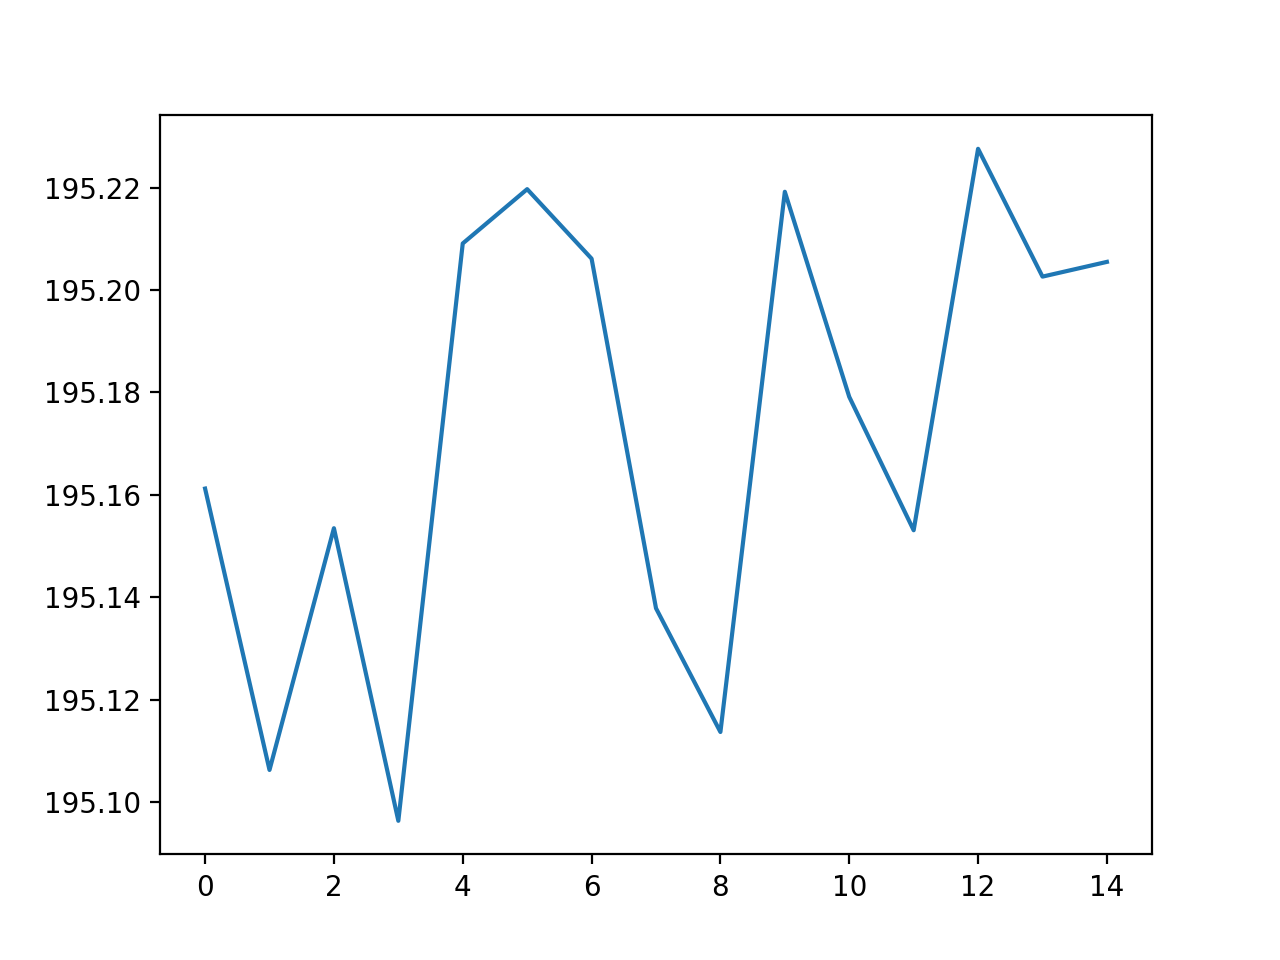

In [38]:
plt.figure()
plt.plot(t_corex_prior_nlls)

In [39]:
W = [x.get_value() for x in tcorex_prior.ws]

In [40]:
print "W_norm = {}".format(np.mean([np.abs(w).mean() for w in W]))

W_norm = 0.103201289202


<IPython.core.display.Javascript object>


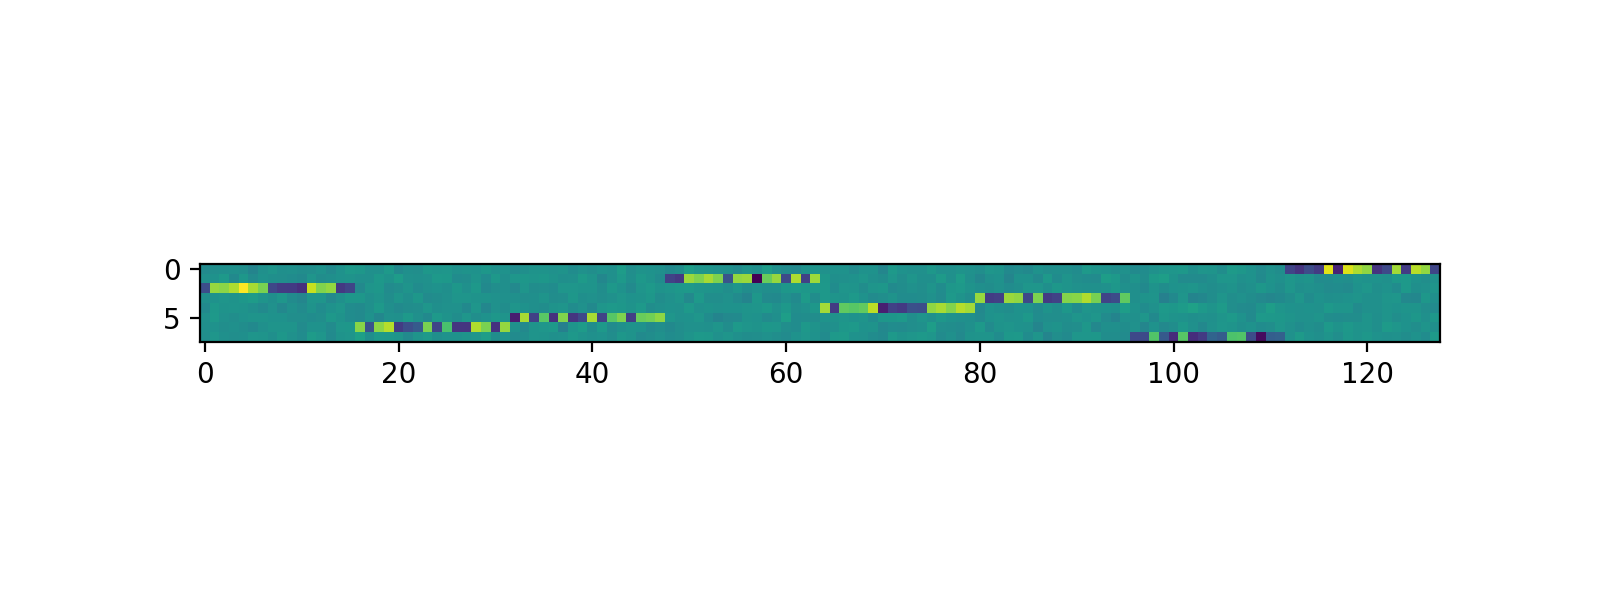

In [41]:
plt.figure(figsize=(8, 3))
plt.imshow(W[0])

In [42]:
print "reg term = {}".format(np.mean([np.mean(np.abs(W[t+1]-W[t])) for t in range(nt-1)]))

reg term = 0.00902795431299


# Use priors for $Z_j^2$ and $R_{ji}$ (method 2)

In [44]:
best_nll = np.inf
best_tcorex_prior2 = None
best_l1 = None
coefs = [0.0, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1, 1.0, 3.0, 10.0, 100.0, 1000.0, 1e4, 1e5, 1e6]
t_corex_prior_nlls2 = []
for l1 in coefs:
    print "training with l1 = {}".format(l1)
    tcorex_prior2 = theano_time_corex.TimeCorexWPrior2(nt=nt,
                                                    nv=nv,
                                                    n_hidden=m,
                                                    max_iter=500,
                                                    verbose=False,
                                                    anneal=True,
                                                    l1=l1,
                                                    lamb=0.9)
    tcorex_prior2.fit(train_data)
    covs = tcorex_prior2.get_covariance()
    nll = metric_utils.calculate_nll_score(data=test_data, covs=covs)
    t_corex_prior_nlls2.append(nll)
    print "l1 = {}, nll = {}".format(l1, nll)
    if np.mean(nll) < best_nll:
        best_nll = np.mean(nll)
        best_tcorex_prior2 = tcorex_prior2
        best_l1 = l1

print "best l1 = {}".format(best_l1)
tcorex_prior2 = best_tcorex_prior2
print sum(tcorex_prior2.tc)

training with l1 = 0.0
Annealing iteration finished, time = 1.04786896706
Annealing iteration finished, time = 1.1157720089
Annealing iteration finished, time = 1.04073405266
Annealing iteration finished, time = 1.12180685997
Annealing iteration finished, time = 1.03721499443
Annealing iteration finished, time = 1.11504912376
Annealing iteration finished, time = 1.03408288956
l1 = 0.0, nll = 246.381333993
training with l1 = 0.001
Annealing iteration finished, time = 1.04186201096
Annealing iteration finished, time = 1.12281990051
Annealing iteration finished, time = 1.03744101524
Annealing iteration finished, time = 1.08720612526
Annealing iteration finished, time = 1.04598903656
Annealing iteration finished, time = 1.10965394974
Annealing iteration finished, time = 1.0345659256
l1 = 0.001, nll = 245.475348008
training with l1 = 0.003
Annealing iteration finished, time = 1.01844000816
Annealing iteration finished, time = 1.10037207603
Annealing iteration finished, time = 1.0139799118
A

In [69]:
tcorex_prior_score2 = best_nll
print "T-Corex with priors (method 2) score = {}".format(tcorex_prior_score2)

T-Corex with priors (method 2) score = 194.998873058


<IPython.core.display.Javascript object>


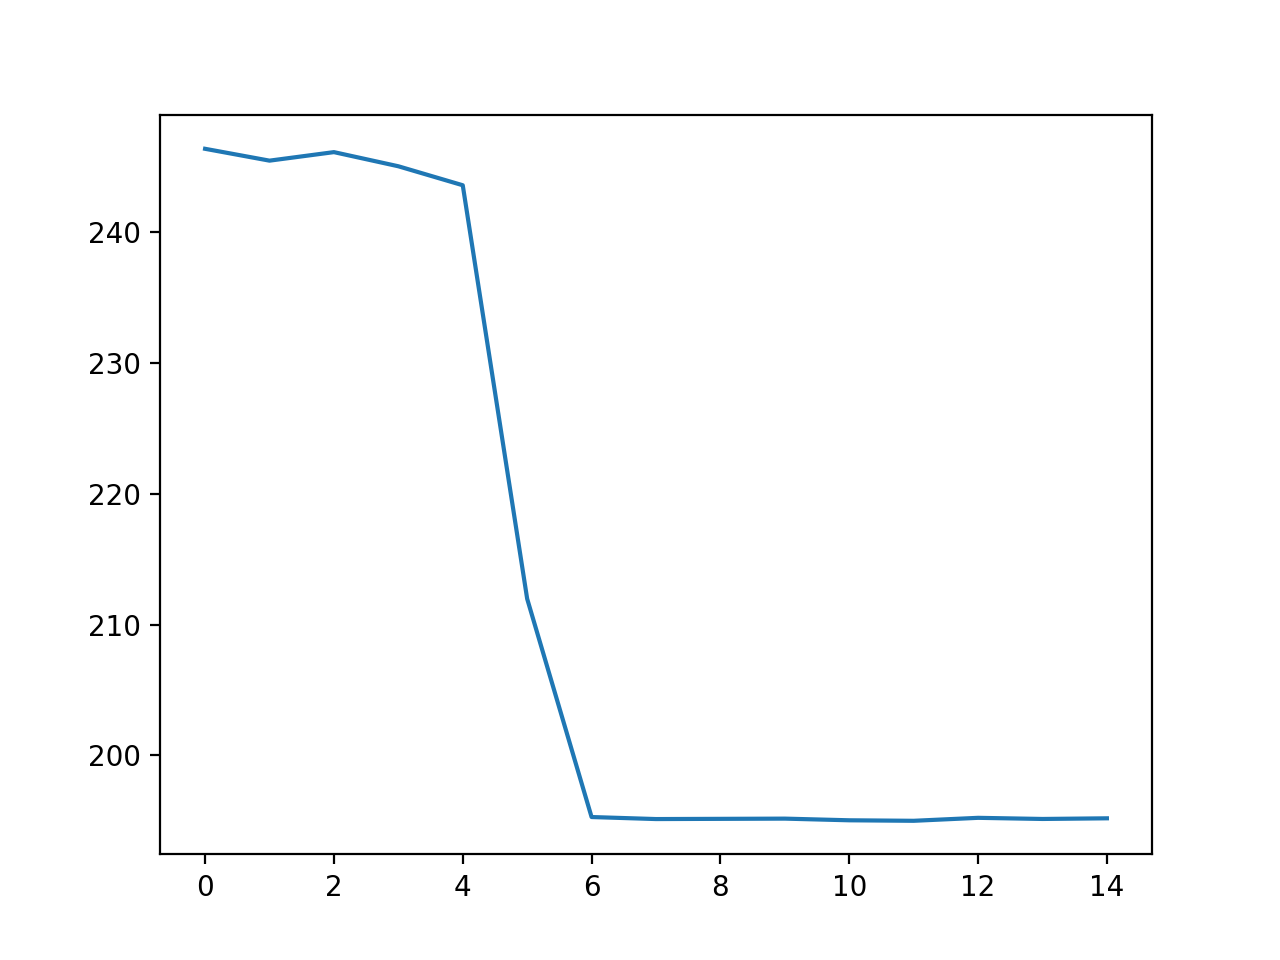

In [70]:
plt.figure()
plt.plot(t_corex_prior_nlls2)

In [71]:
W = [x.get_value() for x in tcorex_prior2.ws]

In [72]:
print "W_norm = {}".format(np.mean([np.abs(w).mean() for w in W]))

W_norm = 0.10823375785


<IPython.core.display.Javascript object>


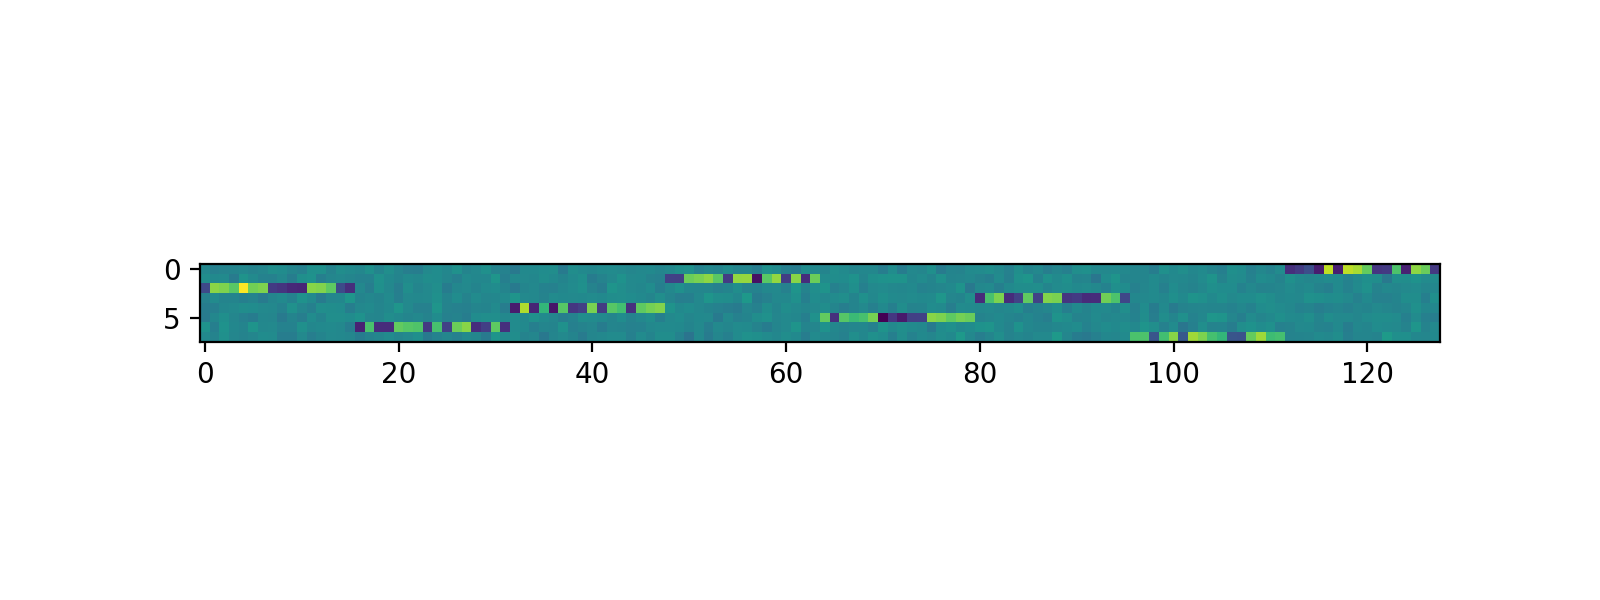

In [74]:
plt.figure(figsize=(8, 3))
plt.imshow(W[0])

In [75]:
print "reg term = {}".format(np.mean([np.mean(np.abs(W[t+1]-W[t])) for t in range(nt-1)]))

reg term = 0.000198573212445


## summary

<IPython.core.display.Javascript object>


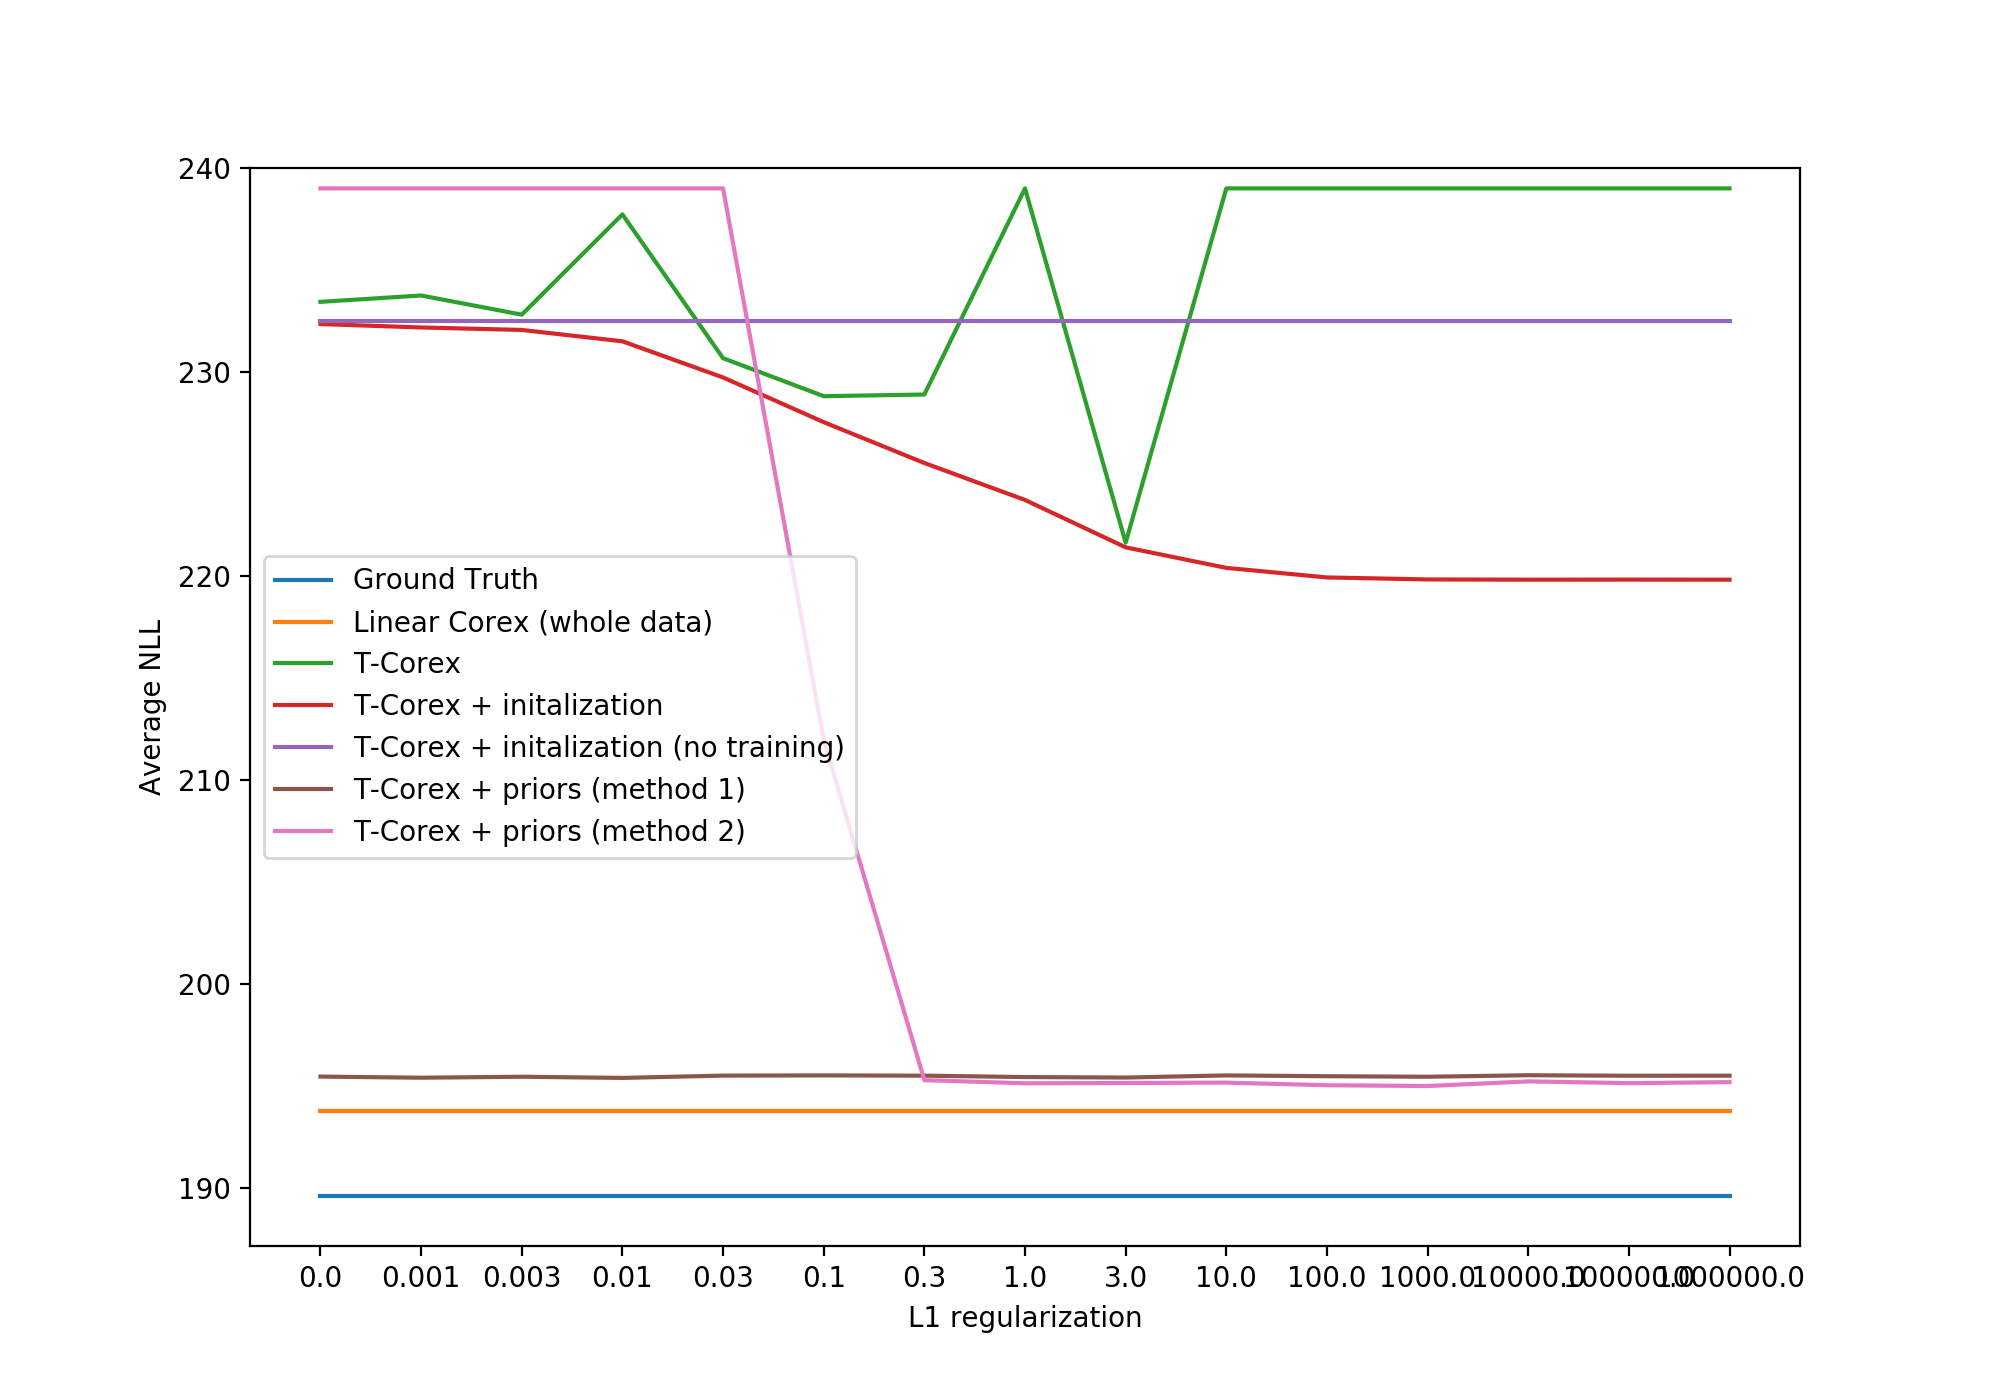

In [77]:
#plt.figure(figsize=(14, 8))
plt.figure(figsize=(10, 7))

plt.plot([0, len(coefs)-1], [grouth_truth_score, grouth_truth_score])
plt.plot([0, len(coefs)-1], [linaer_corex_whole_score, linaer_corex_whole_score])
plt.plot(np.minimum(t_corex_nlls, 239))
plt.plot(t_corex_pre_nlls)
plt.plot([0, len(coefs)-1], [t_corex_no_training_pretrained_score, t_corex_no_training_pretrained_score])
plt.plot(np.array(t_corex_prior_nlls)+0.3)
plt.plot(np.minimum(t_corex_prior_nlls2, 239))

plt.xticks(range(len(coefs)), coefs);
plt.ylim(ymax=240)
plt.legend(['Ground Truth',
           'Linear Corex (whole data)',
           'T-Corex',
           'T-Corex + initalization',
           'T-Corex + initalization (no training)',
           'T-Corex + priors (method 1)',
           'T-Corex + priors (method 2)'])
plt.xlabel('L1 regularization')
plt.ylabel('Average NLL')
plt.show()

## Look at covariance estimates

<IPython.core.display.Javascript object>


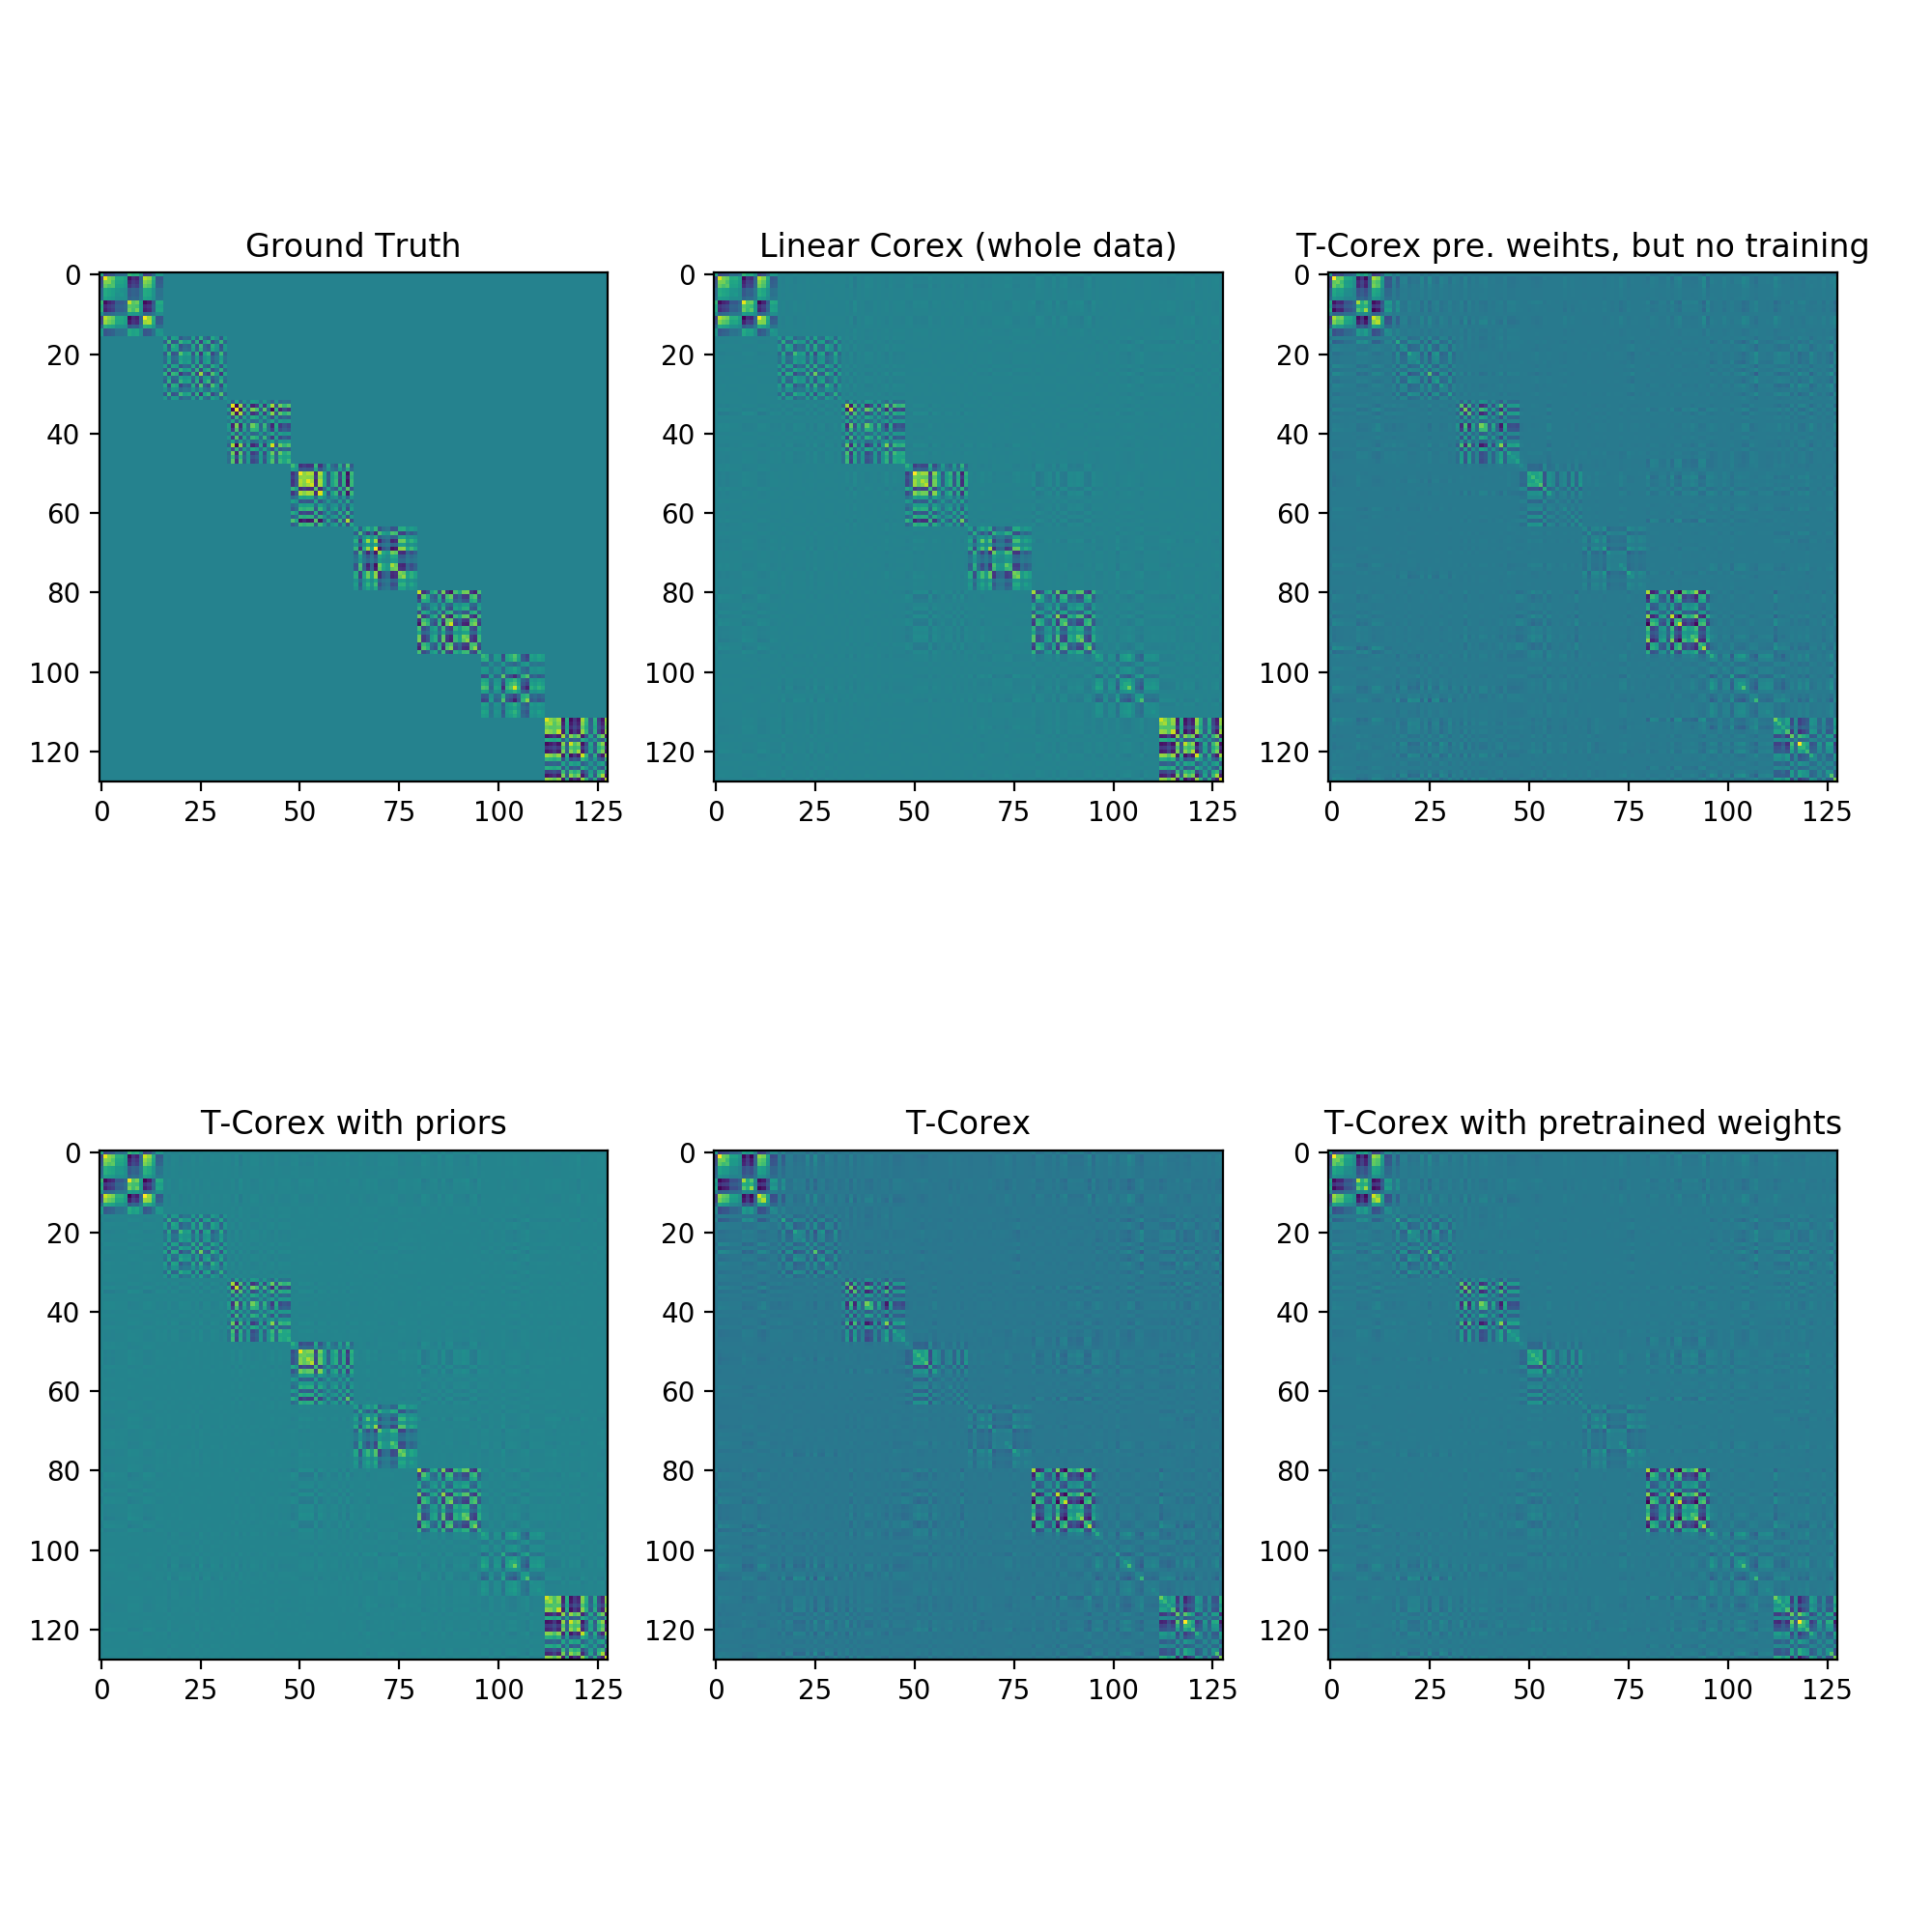

In [67]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,10))
ax[0][0].imshow(ground_truth[0], interpolation='none')
ax[0][0].set_title('Ground Truth')

ax[0][1].imshow(corex.get_covariance(), interpolation='none')
ax[0][1].set_title('Linear Corex (whole data)')

ax[0][2].imshow(no_training.get_covariance()[0], interpolation='none')
ax[0][2].set_title('T-Corex pre. weihts, but no training')

ax[1][0].imshow(tcorex_prior.get_covariance()[0], interpolation='none')
ax[1][0].set_title('T-Corex with priors')

ax[1][1].imshow(tcorex.get_covariance()[0], interpolation='none')
ax[1][1].set_title('T-Corex')

ax[1][2].imshow(tcorex_pre.get_covariance()[0], interpolation='none')
ax[1][2].set_title('T-Corex with pretrained weights')
fig.tight_layout()